# AdventureWorks Sales & Customer Analytics
A comprehensive analysis of sales performance, customer behavior, product trends, and regional insights using the AdventureWorks dataset.

---

## Project Introduction
This project performs an end-to-end analysis on the AdventureWorks retail dataset.
The goal is to build a consolidated analytical dataset and uncover insights across customers, products, sales performance, and regions.

Core components include:
* Data quality assessment
* Cleaning & standardization
* Exploratory Data Analysis (EDA)
* Time-series exploration
* Customer & product performance evaluation
* Insight synthesis

### Business Questions
This project aims to answer:
#### Customer
> - Who are the top revenue-contributing customers?
> - How does spending differ by age, gender, and location?
> - Which customer segments offer the greatest strategic value?
#### Product
> - Which products/categories drive sales and profit?
> - Which items underperform or show declining contribution?
#### Sales & Operations
> - How do sales evolve across years, quarters, and months?
> - Which territories generate the highest revenue?
> - Are delivery performance and order patterns consistent?

### Dataset Description
This analysis integrates seven tables:
| Table           | Description                     |
| --------------- | ------------------------------- |
| InternetSales   | Transaction fact table          |
| Customer        | Demographic details             |
| Product         | Product attributes              |
| ProductCategory | Category hierarchy              |
| Geography       | Regional and city-level details |
| SalesTerritory  | Territory grouping              |
| Employee        | Sales team assignments          |

These tables follow a star schema, where InternetSales serves as the central fact table.

## Data Preparation

---

In [1]:
# Loading Data
import pandas as pd
xls = pd.ExcelFile("AdventureWorks.xlsx")
sheets = xls.sheet_names
print("Sheets:", sheets)

Sheets: ['pbi_Customer', 'pbi_Employee', 'pbi_Product', 'pbi_ProductCategory', 'pbi_SalesTerritory', 'pbi_Geography', 'pbi_InternetSales']


In [2]:
# Parsing sheets into separate dataframe.
dfs = {s: xls.parse(s) for s in sheets}
for name, df in dfs.items():
    print("\n---", name, "---")
    print("shape:", df.shape)
    print("columns:", list(df.columns))
    print("head:")
    print(df.head(3).to_string(index=False))
    print("missing % (top columns):")
    miss = (df.isna().sum() / len(df) * 100).round(3).sort_values(ascending=False)
    print(miss.head(10).to_string())


--- pbi_Customer ---
shape: (18484, 8)
columns: ['CustomerKey', 'FirstName', 'MiddleName', 'LastName', 'BirthDate', 'Gender', 'EmailAddress', 'GeographyKey']
head:
 CustomerKey FirstName MiddleName  LastName  BirthDate Gender                    EmailAddress  GeographyKey
       12518 Jacquelyn        NaN Dominguez 1983-03-27      F jacquelyn13@adventure-works.com           161
       12519     Casey        NaN Gutierrez 1983-06-16      M     casey34@adventure-works.com           265
       12520      Seth          R   Jackson 1982-05-25      M      seth12@adventure-works.com           208
missing % (top columns):
MiddleName      42.361
CustomerKey      0.000
FirstName        0.000
LastName         0.000
BirthDate        0.000
Gender           0.000
EmailAddress     0.000
GeographyKey     0.000

--- pbi_Employee ---
shape: (296, 9)
columns: ['EmployeeKey', 'ParentEmployeeKey', 'SalesTerritoryKey', 'FirstName', 'LastName', 'MiddleName', 'Title', 'LoginID', 'EmailAddress']
head:
 Employe

---
### Data Quality Audit

#### Customer

* MiddleName missing ~42% (non-essential)

* Core demographics complete

#### Product

* Color missing ~41%

* Subcategory missing ~34% → imputed “Unknown Subcategory”

#### Geography

* Fully complete

#### SalesTerritory

* ~9% missing → labeled “Unknown Region”

#### InternetSales

* 564k rows

* No missing values

* Clean timestamps and numeric fields

#### Conclusion
Dataset is structurally sound; only light preprocessing required.

### Data Cleaning & Standardizing

---

#### Data Preparation: Joining Tables & Feature Engineering

To build a complete analytical dataset, we join the main fact table **`pbi_InternetSales`** with several dimension tables:

- **Customer**: demographic attributes such as birth year and gender  
- **Geography**: location details including city, region, and country  
- **Product**: product name, subcategory, and color  
- **Product Category**: higher-level grouping of products  
- **Sales Territory**: regional sales groupings  

This integration transforms raw transactional data into a structured dataset suitable for analysis.

---

#### Engineered Features
We also create new variables to support deeper insights:

- **DeliveryDays** = `ShipDate − OrderDate`  
  Measures fulfillment speed.  
- **CustomerAge** = `AnalysisYear − BirthYear`  
  Enables demographic profiling.  
- **OrderYear, OrderMonth, OrderQuarter**  
  Supports time-series and season

In [3]:
# Standardize references & Fixing Inconsistent Name
customer = dfs["pbi_Customer"].copy()
employee = dfs["pbi_Employee"].copy()
product = dfs["pbi_Product"].copy()
product_cat = dfs["pbi_ProductCategory"].copy()
territory = dfs["pbi_SalesTerritory"].copy()
geo = dfs["pbi_Geography"].copy()
sales = dfs["pbi_InternetSales"].copy()

geo.rename(columns={
    "Geography Key": "GeographyKey",
    "State Province": "StateProvince"
}, inplace=True)

# Converting dates to datetime dtype
sales["OrderDate"] = pd.to_datetime(sales["OrderDate"])
sales["ShipDate"] = pd.to_datetime(sales["ShipDate"])
customer["BirthDate"] = pd.to_datetime(customer["BirthDate"])

# Clean product subcategory nulls
product["ProductSubcategoryKey"] = product["ProductSubcategoryKey"].fillna(-1)
# Clean color nulls
product["Color"] = product["Color"].fillna("Unknown")
# Create unknown text fields for empty territory
territory = territory.fillna("Unknown")

In [4]:
# Join Customer + Geography
cust_geo = customer.merge(
    geo,
    on="GeographyKey",
    how="left"
)

# Join Product + Category
prod_full = product.merge(
    product_cat,
    left_on="ProductSubcategoryKey",
    right_on="ProductCategoryKey",
    how="left"
)

# Territory join
sales_terr = sales.merge(territory, on="SalesTerritoryKey", how="left")

# Join Sales with Customer+Geo
df = sales_terr.merge(
    cust_geo,
    on="CustomerKey",
    how="left"
)

# Join Sales with Product+Category
df = df.merge(
    prod_full,
    on="ProductKey",
    how="left"
)

# ============================= FEATURE ENGINEERING =============================
# Delivery duration
df["DeliveryDays"] = (df["ShipDate"] - df["OrderDate"]).dt.days

# Time breakdown
df["OrderYear"] = df["OrderDate"].dt.year
df["OrderMonth"] = df["OrderDate"].dt.month
df["OrderQuarter"] = df["OrderDate"].dt.quarter

# Customer age (approx)
df["CustomerAge"] = df["OrderYear"] - df["BirthDate"].dt.year

# Profit estimate (gross margin proxy)
df["ProfitEstimate"] = df["SalesAmount"] - df["TaxAmt"] - df["Freight"]

# Replace missing categoricals
df.fillna({
    "Color": "Unknown",
    "EnglishProductCategoryName": "Unknown Category",
    "StateProvince": "Unknown",
    "Country": "Unknown",
    "SalesTerritoryRegion": "Unknown Region",
    "SalesTerritoryCountry": "Unknown Country",
    "SalesTerritoryGroup": "Unknown Group"
}, inplace=True)

# Display structure summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564828 entries, 0 to 564827
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   ProductKey                  564828 non-null  int64         
 1   SalesTerritoryKey           564828 non-null  int64         
 2   CustomerKey                 564828 non-null  int64         
 3   OrderDate                   564828 non-null  datetime64[ns]
 4   ShipDate                    564828 non-null  datetime64[ns]
 5   OrderQuantity               564828 non-null  int64         
 6   SalesAmount                 564828 non-null  float64       
 7   TaxAmt                      564828 non-null  float64       
 8   Freight                     564828 non-null  float64       
 9   SalesTerritoryAlternateKey  564828 non-null  int64         
 10  SalesTerritoryRegion        564828 non-null  object        
 11  SalesTerritoryCountry       564828 non-

## Exploratory Data Analysis (EDA)

The purpose of this section is to explore the dataset and uncover patterns in sales, customer behavior, product performance, and geographic trends.  
We will use a combination of descriptive statistics and visualizations to guide our understanding.

### Univariate Analysis

This section explores the distribution of key variables to understand overall sales behavior, profitability, customer demographics, and operational patterns.

---

#### Sales Amount Distribution
The distribution of sales values is **strongly right-skewed**, with a high frequency of low-value transactions near zero. As sales amounts increase, frequency drops sharply, but a **long tail extends up to ~2500–3000 USD**, representing premium products such as high-end bike frames.

**Key observations:**
- Most orders are low-value (<50 USD).
- A small number of high-value items create the long tail.
- This reflects a **long-tail retail pattern**, typical of catalogs with both entry-level and premium products.

---

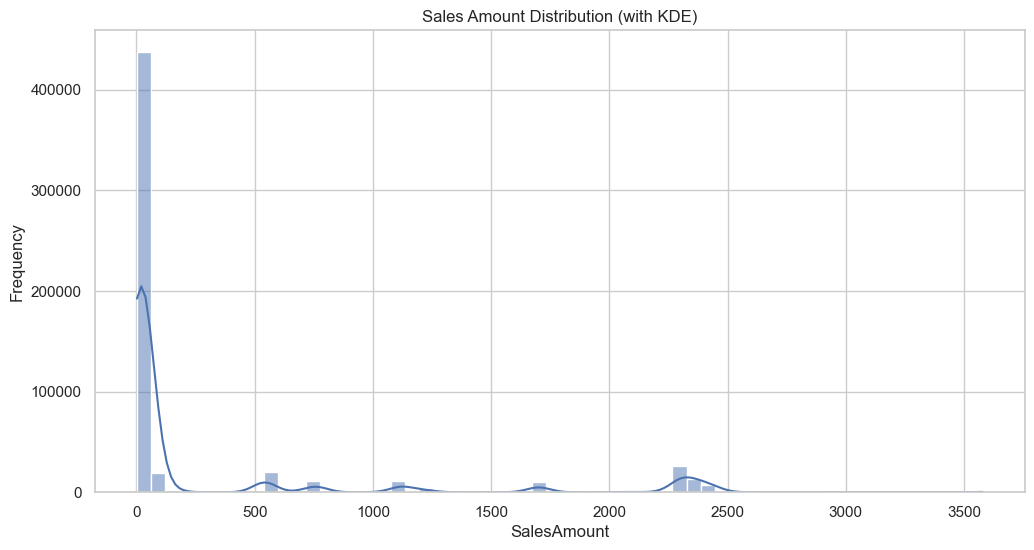

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Sales Amount Distribution
plt.figure(figsize=(12,6))
sns.histplot(df['SalesAmount'], bins=60, kde=True)
plt.title("Sales Amount Distribution (with KDE)")
plt.xlabel("SalesAmount")
plt.ylabel("Frequency")
plt.show()

#### Profit Estimate Distribution
Profit follows a similar right-skewed pattern as sales, but the tail peaks around **~2000 USD instead of 3000 USD**. This suggests that some high-priced items generate lower margins.

**Key observations:**
- Profit distribution mirrors sales volume.
- Margin variability exists across product categories.
- This will be important later when identifying **high-revenue but low-margin SKUs**.

---

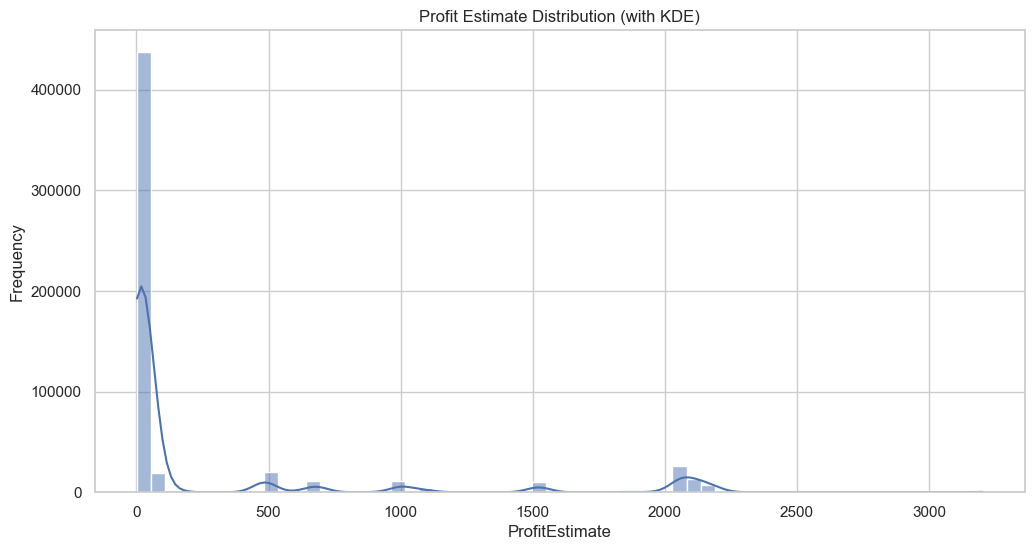

In [6]:
# Profit Estimate Distribution
plt.figure(figsize=(12,6))
sns.histplot(df['ProfitEstimate'], bins=60, kde=True)
plt.title("Profit Estimate Distribution (with KDE)")
plt.xlabel("ProfitEstimate")
plt.ylabel("Frequency")
plt.show()

#### Customer Age Distribution
Customer age is **mildly left-skewed**, with most buyers concentrated in the **30–50 age range**. The distribution peaks around age 40 and gradually declines toward older ages.

**Key observations:**
- Younger to middle-aged adults dominate transactions.
- Age spans broadly from 25 to ~84, showing wide customer reach.
- Useful for **demographic segmentation** and age-based product preference analysis.

---

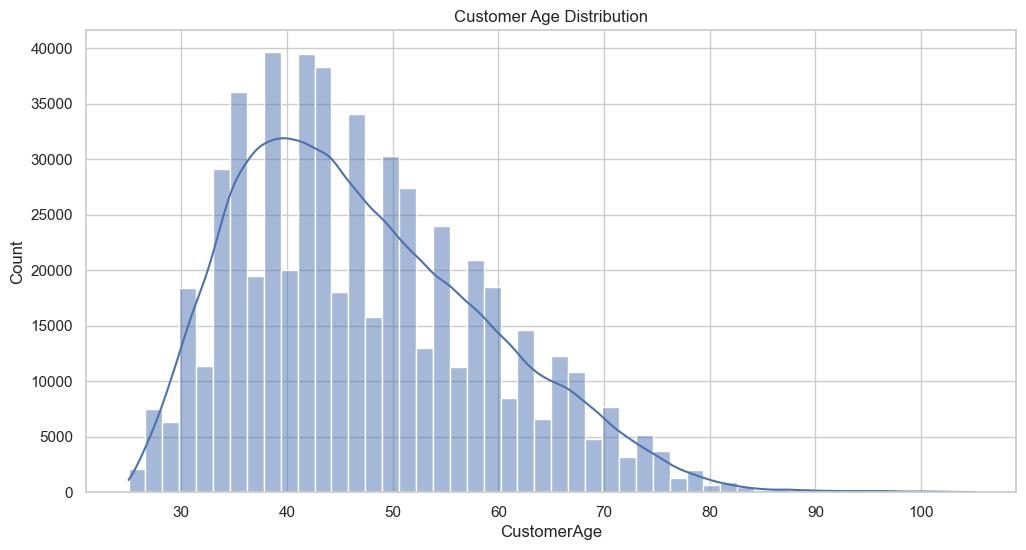

In [7]:
# Customer Age Distribution
plt.figure(figsize=(12,6))
sns.histplot(df['CustomerAge'], bins=50, kde=True)
plt.title("Customer Age Distribution")
plt.xlabel("CustomerAge")
plt.ylabel("Count")
plt.show()

#### DeliveryDays Distribution
DeliveryDays shows a **constant value of 7 days** across all records, indicating a fixed service-level agreement (SLA).

**Key observations:**
- Delivery time has zero variance.
- No operational differences between customers or regions.
- This variable will be dropped during feature selection but noted for context (fixed SLA).

---

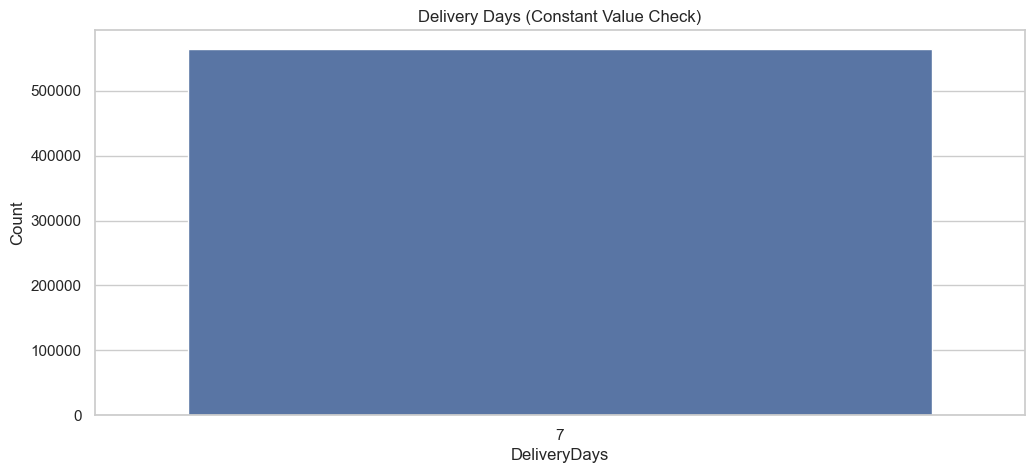

In [8]:
# Delivery Days Distribution
plt.figure(figsize=(12,5))
sns.countplot(x=df['DeliveryDays'])
plt.title("Delivery Days (Constant Value Check)")
plt.xlabel("DeliveryDays")
plt.ylabel("Count")
plt.show()

### Time-Series Analysis
We now move to analyzing sales patterns across **year, quarter, and month** to reveal seasonality, growth trends, and peak periods.

---

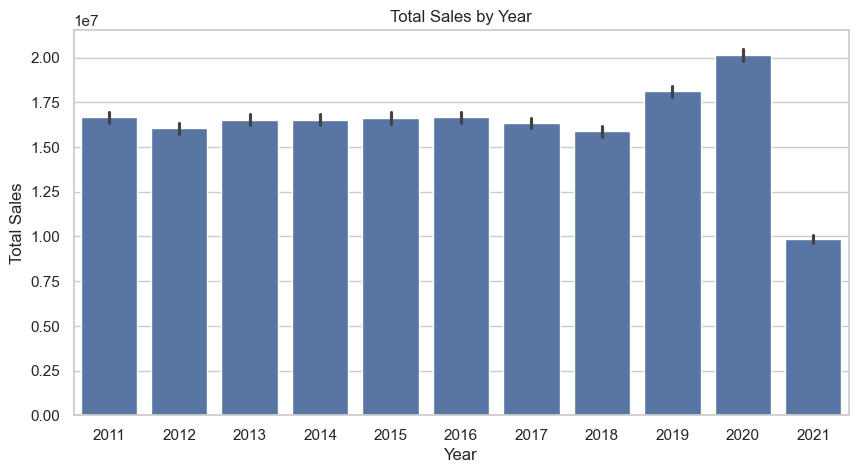

In [9]:
# Sales by Year
plt.figure(figsize=(10,5))
sns.barplot(x='OrderYear', y='SalesAmount', data=df, estimator='sum')
plt.title("Total Sales by Year")
plt.ylabel("Total Sales")
plt.xlabel("Year")
plt.show()

#### Total Sales by Year
Between **2011 and 2018**, sales remained relatively stable, fluctuating around **1.55–1.6×10⁷ USD** annually.  
In **2019**, revenue rose to approximately **1.8×10⁷ USD**, followed by a sharp spike in **2020**, which marked the overall peak at nearly **2×10⁷ USD**.  However, **2021 saw a steep decline to ~1×10⁷ USD**, the lowest point in the dataset.

**Interpretation:** The business maintained long-term stability, experienced a sudden boom in 2020, and then faced an abrupt contraction the following year. This pattern may reflect external shocks (e.g., market disruptions or global events) impacting demand.

---

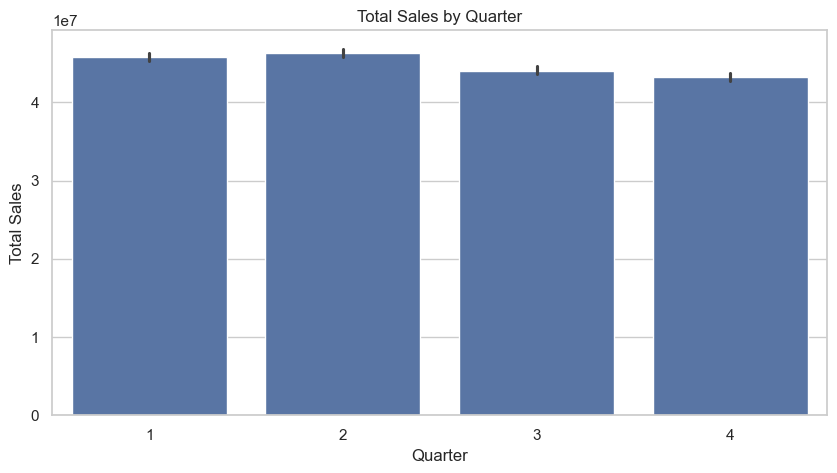

In [10]:
# Sales by Quarter
plt.figure(figsize=(10,5))
sns.barplot(x='OrderQuarter', y='SalesAmount', data=df, estimator='sum')
plt.title("Total Sales by Quarter")
plt.ylabel("Total Sales")
plt.xlabel("Quarter")
plt.show()

#### Total Sales by Quarter
Quarterly analysis shows **Q2 as the strongest performer (~4.7×10⁷ USD)**, closely followed by **Q1 (~4.6×10⁷ USD)**.  
Sales dip slightly in **Q3 (~4.4×10⁷ USD)** and reach their lowest in **Q4 (~4.2×10⁷ USD)**.

**Interpretation:** Demand is concentrated in the **first half of the year**, suggesting seasonal peaks tied to early-year purchasing cycles. Q4 underperformance may indicate weaker holiday sales compared to other industries.

---

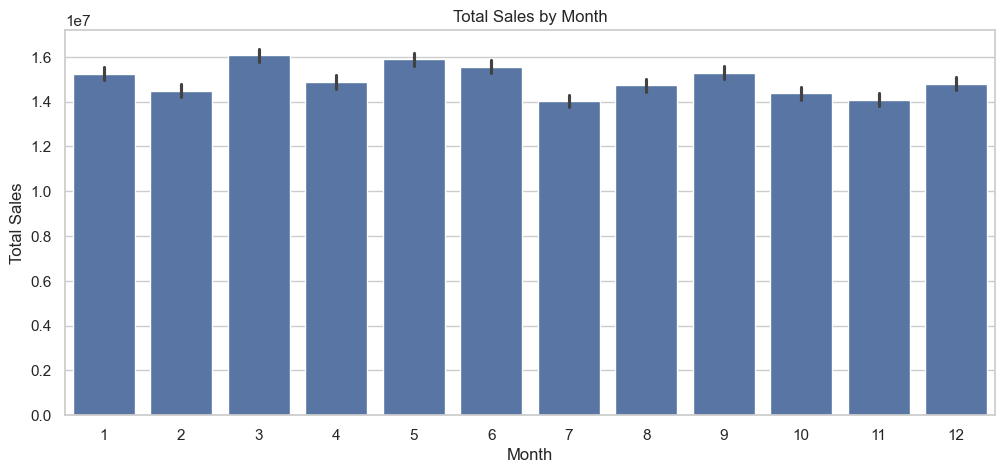

In [11]:
# Sales by Month
plt.figure(figsize=(12,5))
sns.barplot(x='OrderMonth', y='SalesAmount', data=df, estimator='sum')
plt.title("Total Sales by Month")
plt.ylabel("Total Sales")
plt.xlabel("Month")
plt.show()

#### Total Sales by Month
At the monthly level, **March (Month 3)** stands out as the top performer with **1.6×10⁷ USD** in sales.  
**May (Month 5)** and **June (Month 6)** also show strong results (1.58×10⁷ and 1.55×10⁷ USD).  
In contrast, **July (Month 7)** and **November (Month 11)** are the weakest months, both at **1.4×10⁷ USD**.

**Interpretation:** Sales intensify in **late Q1 and early Q2**, indicating strong spring demand. Mid-year (July) and late-year (November) dips highlight potential opportunities for targeted promotions or inventory adjustments during these weaker periods.

---

## Product Performance Deep Dive

### Objective
This section analyzes product-level performance to identify revenue drivers, underperformers, seasonal patterns, and category contributions. The goal is to highlight which products sustain growth, which are declining, and where marketing or inventory budgets should be focused.

---

### Top Products by Revenue and Profit

In [12]:
# 1. Top products by revenue and profit
top_products = df.groupby(['ProductKey','EnglishProductName']).agg(
    revenue=('SalesAmount','sum'),
    profit=('ProfitEstimate','sum'),
    transactions=('ProductKey','count')
).reset_index().sort_values('revenue', ascending=False)

top_products.head(20)

,ProductKey,EnglishProductName,revenue,profit,transactions
47,353,"Mountain-200 Silver, 38",10416755.10,9.322996e+06,4490
55,361,"Mountain-200 Black, 42",10338929.95,9.253342e+06,4505
53,359,"Mountain-200 Black, 38",10254015.32,9.177343e+06,4468
51,357,"Mountain-200 Silver, 46",9910997.28,8.870342e+06,4272
57,363,"Mountain-200 Black, 46",9856982.05,8.821999e+06,4295
49,355,"Mountain-200 Silver, 42",9583878.69,8.577571e+06,4131
128,573,"Touring-1000 Blue, 46",4591718.82,4.109588e+06,1926
135,580,"Road-350-W Yellow, 40",4468500.73,3.999308e+06,2627
116,561,"Touring-1000 Yellow, 46",4279405.65,3.830068e+06,1795
138,583,"Road-350-W Yellow, 48",4238867.08,3.793786e+06,2492


The **Mountain-200 series** (Silver and Black variants across multiple sizes) dominate product-level revenue, each generating ~USD 9–10M with strong profit margins and high transaction counts (4,000–4,500 orders). Secondary contributors include **Touring-1000** (Blue and Yellow variants) and **Road-350-W Yellow**, each in the USD 3.8–4.6M range.  These results confirm that premium bike models are the primary revenue drivers, with Road and Touring categories providing additional support.

**Interpretation:** Product-level sales are concentrated in a handful of high-value SKUs, particularly Mountain-200 variants, which form the backbone of revenue.

---


### Category-Level Performance

In [13]:
# 2. Category-level performance
cat_perf = df.groupby(['EnglishProductCategoryName']).agg(
    revenue=('SalesAmount','sum'),
    profit=('ProfitEstimate','sum'),
    avg_price=('SalesAmount','mean'),
    transactions=('SalesAmount','count')
).reset_index().sort_values('revenue', ascending=False)

cat_perf

,EnglishProductCategoryName,revenue,profit,avg_price,transactions
0,Bikes,6.947568e+07,6.218074e+07,1826.048953,38047
2,Components,5.819015e+07,5.208018e+07,1300.048007,44760
1,Clothing,4.117489e+07,3.685152e+07,1781.768442,23109
3,Unknown Category,1.057220e+07,9.462103e+06,23.037542,458912


At the category level, **Bikes** dominate with the highest revenue (USD 69.5M) and profit (USD 62.2M), reflecting their premium positioning despite fewer transactions.  **Components** follow closely (USD 58.2M revenue, USD 52.1M profit) with the largest transaction volume, highlighting strong demand for accessories and upgrades.  **Clothing** contributes USD 41.2M with relatively high average prices but lower transaction counts, suggesting a niche yet premium apparel market.  The **Unknown Category**, though modest in revenue (USD 10.6M), shows extremely high transaction volume at very low average prices, indicating either small-ticket consumables or data quality issues.

**Interpretation:** The portfolio balances high-value premium products with high-frequency low-value items, but concentration risk in Bikes and the ambiguity of the Unknown segment warrant closer attention.

---

### Growth and Decline Patterns.


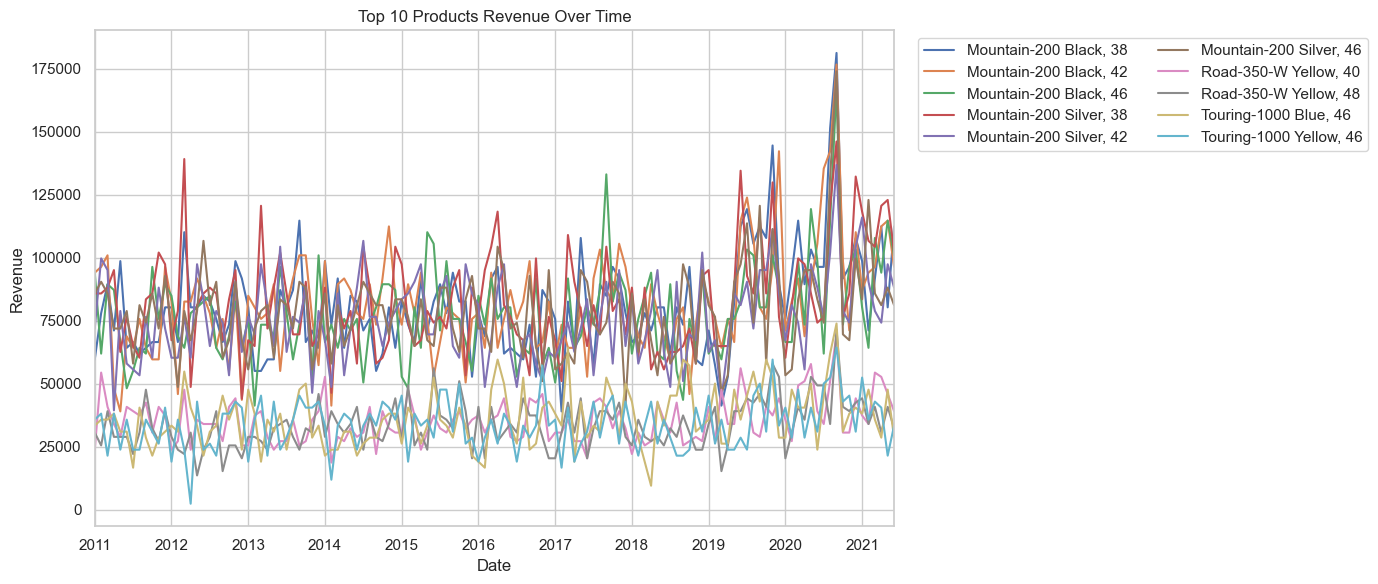

In [14]:
# 3. Top N products over time (monthly)
top_n = top_products.head(10)['ProductKey'].tolist()
ts_top_products = (df[df['ProductKey'].isin(top_n)]
                   .groupby(['OrderYear','OrderMonth','ProductKey','EnglishProductName'])
                   .agg(revenue=('SalesAmount','sum'))
                   .reset_index())
# Pivot for plotting convenience
ts_pivot = ts_top_products.pivot_table(index=['OrderYear','OrderMonth'],
                                       columns='EnglishProductName',
                                       values='revenue',
                                       aggfunc='sum').fillna(0)
# Convert index to datetime for plotting
ts_pivot.index = pd.to_datetime([f"{y}-{m}-01" for y,m in ts_pivot.index])
ts_pivot.plot(figsize=(14,6))
plt.title("Top 10 Products Revenue Over Time")
plt.ylabel("Revenue")
plt.xlabel("Date")
plt.legend(ncol=2, bbox_to_anchor=(1.02,1), loc='upper left')
plt.tight_layout()
plt.show()

Time-series analysis of the top 10 products reveals lifecycle dynamics:  
- **Mountain-200 Silver** and **Road-350-W Yellow** showed strong growth between 2014–2016, but later stabilized or declined.  
- **Touring-1000 Yellow** and **Mountain-200 Black (size 46)** have experienced gradual decline since 2017, likely due to market saturation or shifting preferences.  

**Interpretation:** Certain SKUs have passed their growth phase and may require repositioning or phase-out. Monitoring lifecycle trends is essential to avoid over-investment in declining products.

### High-Revenue but Low-Margin Products

In [15]:
# 4. High-revenue but low-margin products
top_products['margin_pct'] = top_products['profit'] / top_products['revenue']
# Filter products with revenue in top 20% but margin in bottom 40%
rev_thresh = top_products['revenue'].quantile(0.80)
margin_thresh = top_products['margin_pct'].quantile(0.40)
problem_products = top_products[(top_products['revenue'] >= rev_thresh) & (top_products['margin_pct'] <= margin_thresh)]
problem_products[['ProductKey','EnglishProductName','revenue','profit','margin_pct']].sort_values('revenue', ascending=False)

,ProductKey,EnglishProductName,revenue,profit,margin_pct
158,606,"Road-750 Black, 52",2247978.37,2011940.433,0.895
157,605,"Road-750 Black, 48",2108660.95,1887251.355,0.895
156,604,"Road-750 Black, 44",1975823.41,1768361.769,0.895
139,584,"Road-750 Black, 58",1871605.34,1675086.606,0.895


Among the top revenue generators, **Road-750 Black variants (sizes 44, 48, 52, 58)** stand out with revenues of USD 1.8–2.2M each and margins around 89.5%.  
While profitable, these margins are flagged as relatively low compared to peers, suggesting pricing or cost structure issues.

**Interpretation:** High-revenue but lower-margin products require careful review to ensure profitability is sustainable.

---

### Concentration Risk

In [16]:
# 1. Aggregate revenue & profit by SKU
sku_perf = df.groupby(['ProductKey', 'EnglishProductName'], as_index=False).agg(
    revenue=('SalesAmount', 'sum'),
    profit=('ProfitEstimate', 'sum'),
    quantity=('OrderQuantity', 'sum')
)

# 2. Compute margin percentage
sku_perf['margin_pct'] = sku_perf['profit'] / sku_perf['revenue']

# 3. Rank SKUs by revenue
sku_perf = sku_perf.sort_values('revenue', ascending=False).reset_index(drop=True)
sku_perf['rank'] = sku_perf.index + 1

# 4. Compute cumulative revenue share
total_rev = sku_perf['revenue'].sum()
sku_perf['cum_rev_share'] = sku_perf['revenue'].cumsum() / total_rev

# 5. Identify the top contributors (Pareto — first SKUs to reach 80% of revenue)
pareto_cutoff = sku_perf[sku_perf['cum_rev_share'] <= 0.80]

# Display
print("Total SKUs:", len(sku_perf))
print("SKUs contributing to 80% revenue:", len(pareto_cutoff))
pareto_cutoff.head(20)

Total SKUs: 159
SKUs contributing to 80% revenue: 30


,ProductKey,EnglishProductName,revenue,profit,quantity,margin_pct,rank,cum_rev_share
0,353,"Mountain-200 Silver, 38",10416755.10,9.322996e+06,4490,0.895,1,0.058060
1,361,"Mountain-200 Black, 42",10338929.95,9.253342e+06,4505,0.895,2,0.115687
2,359,"Mountain-200 Black, 38",10254015.32,9.177343e+06,4468,0.895,3,0.172840
3,357,"Mountain-200 Silver, 46",9910997.28,8.870342e+06,4272,0.895,4,0.228081
4,363,"Mountain-200 Black, 46",9856982.05,8.821999e+06,4295,0.895,5,0.283021
5,355,"Mountain-200 Silver, 42",9583878.69,8.577571e+06,4131,0.895,6,0.336439
6,573,"Touring-1000 Blue, 46",4591718.82,4.109588e+06,1926,0.895,7,0.362032
7,580,"Road-350-W Yellow, 40",4468500.73,3.999308e+06,2627,0.895,8,0.386939
8,561,"Touring-1000 Yellow, 46",4279405.65,3.830068e+06,1795,0.895,9,0.410791
9,583,"Road-350-W Yellow, 48",4238867.08,3.793786e+06,2492,0.895,10,0.434417


The Pareto analysis shows that out of **159 SKUs**, only **30 products contribute to 80% of total revenue**.  Within this group, the **Mountain-200 series (Silver and Black variants)** dominate, each generating ~USD 9–10M in revenue and accounting for the top five positions. Secondary contributors include **Touring-1000** (Blue and Yellow variants) and **Road-350-W Yellow**, each in the USD 3.8–4.6M range.  

**Interpretation:** Revenue is highly concentrated in a small set of premium bike SKUs. While this concentration drives profitability, it also creates portfolio fragility — any disruption in demand or supply for these products would significantly impact overall performance. Diversification into mid-tier or emerging products is necessary to reduce dependency and stabilize revenue streams.

### Strategic Recommendations

The analysis highlights both strengths and vulnerabilities across products and categories. To ensure sustainable growth and reduce risk:

- **Diversify revenue sources:** Heavy reliance on Mountain-200 and Road-750 variants creates portfolio fragility. Expand mid-tier offerings and nurture emerging SKUs to balance revenue streams.  
- **Optimize margins:** Review pricing and cost structures for high-revenue but flagged low-margin products (e.g., Road-750 Black variants) to improve profitability without sacrificing demand.  
- **Lifecycle management:** Monitor declining SKUs (e.g., Touring-1000 Yellow, Mountain-200 Black size 46) for potential phase-out or repositioning, while investing in products with stable or rising demand.  
- **Category expansion:** Strengthen Components and Clothing categories to spread revenue more evenly and reduce concentration risk in Bikes.  
- **Seasonality alignment:** Align marketing and inventory strategies with demand peaks in Q2 and Q4, especially for outdoor-oriented SKUs like Road-350-W Yellow.  
- **Risk mitigation:** Build contingency plans for supply chain disruptions affecting top SKUs, including alternative sourcing and inventoryrtunities.
formance.


## Regional Sales Profiling

### Objective
This section evaluates revenue distribution across regions to detect growth opportunities, weak markets, and geographical trends. The analysis highlights which territories drive performance, which underperform, and where expansion or targeted strategies may be most effective.

---

### Identifying Strongest and Weakest Regions

In [17]:
# 1. Territory & country aggregates
territory_perf = df.groupby(['SalesTerritoryGroup','SalesTerritoryRegion','SalesTerritoryCountry']).agg(
    revenue=('SalesAmount','sum'),
    profit=('ProfitEstimate','sum'),
    transactions=('SalesAmount','count'),
).reset_index().sort_values('revenue', ascending=False)

territory_perf.head(20)

,SalesTerritoryGroup,SalesTerritoryRegion,SalesTerritoryCountry,revenue,profit,transactions
9,Pacific,Australia,Australia,4.724773e+07,4.228671e+07,117945
8,North America,Southwest,United States,3.743109e+07,3.350082e+07,117537
6,North America,Northwest,United States,2.315191e+07,2.072095e+07,84609
2,Europe,United Kingdom,United Kingdom,2.297918e+07,2.056636e+07,65841
1,Europe,Germany,Germany,1.930001e+07,1.727351e+07,53450
0,Europe,France,France,1.717967e+07,1.537580e+07,52211
3,North America,Canada,Canada,1.195324e+07,1.069815e+07,72359
7,North America,Southeast,United States,1.065824e+05,9.539128e+04,331
5,North America,Northeast,United States,5.175537e+04,4.632104e+04,302
4,North America,Central,United States,1.175982e+04,1.052503e+04,243


**Australia (Pacific Group)** leads all markets with **USD 47.2M in revenue and 117,945 transactions**, making it the top-performing country.  
The **Southwest US (North America)** follows closely with **USD 37.4M in revenue and 117,537 transactions**, reflecting a highly competitive domestic market.  
In contrast, the **Central, Northeast, and Southeast US regions** generate minimal revenue (<USD 0.2M) and low transaction volumes, signaling underperformance.

**Interpretation:** Pacific and Southwest US are mature, high-performing markets, while several US regions lag significantly. These weaker territories may require targeted interventions such as localized campaigns or improved distribution.

---

### Customer Value Differences

In [18]:
# 2. Per-customer revenue by territory: average CLV proxy
cust_territory = df.groupby(['SalesTerritoryGroup','CustomerKey']).agg(revenue=('SalesAmount','sum')).reset_index()
territory_cust_rev = cust_territory.groupby('SalesTerritoryGroup').agg(
    total_revenue=('revenue','sum'),
    avg_revenue_per_customer=('revenue','mean'),
    median_revenue_per_customer=('revenue','median'),
    customers=('CustomerKey','nunique')
).reset_index().sort_values('total_revenue', ascending=False)

territory_cust_rev

,SalesTerritoryGroup,total_revenue,avg_revenue_per_customer,median_revenue_per_customer,customers
1,North America,7.270634e+07,8001.137931,1336.26,9087
0,Europe,5.945886e+07,10903.880068,1967.88,5453
2,Pacific,4.724773e+07,13179.282125,6814.06,3585


The **Pacific Group** shows the highest **average revenue per customer (USD 13.2K)**, suggesting strong engagement and premium product uptake. **Europe** demonstrates a higher **median revenue per customer** than North America, indicating a more balanced distribution of customer value. **North America** has the largest customer base (9,087), but a lower median CLV (~USD 1.3K), hinting at a long-tail distribution with upsell potential.

**Interpretation:** Pacific customers deliver premium value, Europe maintains balanced customer contributions, and North America’s large base offers scale but requires strategies to lift average spend.

---

### Category Strength by Region

In [19]:
# 3. Territory x Category pivot
territory_category = df.groupby(['SalesTerritoryGroup','EnglishProductCategoryName']).agg(
    revenue=('SalesAmount','sum')
).reset_index()
pivot_tc = territory_category.pivot(index='SalesTerritoryGroup', columns='EnglishProductCategoryName', values='revenue').fillna(0)
pivot_tc

EnglishProductCategoryName,Bikes,Clothing,Components,Unknown Category
SalesTerritoryGroup,,,,
Europe,2.438265e+07,13564676.19,1.858421e+07,2927319.87
North America,3.178510e+07,17183801.88,1.822386e+07,5513580.77
Pacific,1.330794e+07,10426408.86,2.138207e+07,2131303.96



Across regions, product category strengths reveal distinct market preferences. In **Europe**, Clothing leads with USD 13.6M in revenue, driven by strong apparel demand—particularly in the UK and Germany—highlighting fashion-conscious consumer behavior. **North America** is dominated by Bikes, generating USD 31.8M, reflecting a robust market for performance gear and cycling accessories. Meanwhile, the **Pacific** region shows a preference for Components, contributing USD 21.4M, indicating a thriving premium aftermarket and upgrade culture. These insights suggest that regional strategies should align with category strengths to maximize engagement and revenue.

**Interpretation:** Each region has distinct category strengths — Europe in apparel, North America in bikes, and Pacific in components. This highlights the need for region-specific product strategies.

---

### Regional Performance Trends

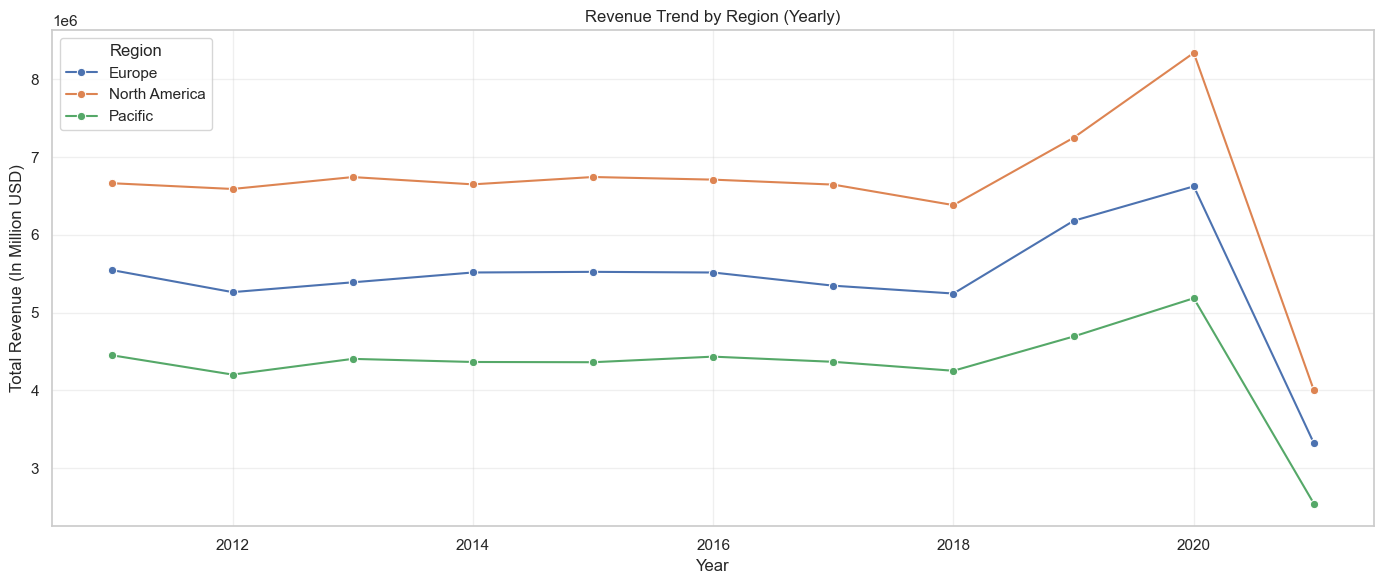

In [20]:
# === Regional Performance Trends (Revenue & Profit Over Time) ===

# Aggregate: Yearly revenue & profit per region
region_trend = df.groupby(
    ['OrderYear', 'SalesTerritoryGroup'], 
    as_index=False
).agg(
    revenue=('SalesAmount', 'sum'),
    profit=('ProfitEstimate', 'sum'),
    quantity=('OrderQuantity', 'sum')
)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=region_trend,
    x='OrderYear',
    y='revenue',
    hue='SalesTerritoryGroup',
    marker='o'
)
plt.title('Revenue Trend by Region (Yearly)')
plt.ylabel('Total Revenue (In Million USD)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.legend(title='Region')
plt.tight_layout()
plt.show()

The regional revenue trends from 2012 to 2021 reveal distinct market behaviors and shared volatility across Europe, North America, and Pacific. **Europe** demonstrated consistent growth through 2019, culminating in a sharp peak in 2020 before experiencing a steep decline in 2021, indicating strong market momentum disrupted by external factors. **North America** followed a similar trajectory, with gradual growth until 2018, a dip in 2019, and a dramatic surge in 2020—likely driven by pandemic-related demand—followed by a sharp contraction in 2021. **Pacific** remained relatively stable throughout the decade, with modest fluctuations and a noticeable rise in 2020, then a decline mirroring the global correction in 2021. These patterns suggest that while all regions benefited from a temporary demand spike in 2020, the subsequent drop in 2021 reflects market normalization. Europe stands out for its long-term growth potential, North America for its volatility and scale, and Pacific for its operational stability. Strategic planning should account for these regional dynamics to ensure resilience and targeted growth.

---

### Strategic Recommendations
- **Expand marketing and inventory** in high-CLV regions like Pacific, especially for premium components.  
- **Reassess product mix** in underperforming US regions; consider localized campaigns or bundling strategies.  
- **Leverage Europe’s balanced demand** by promoting cross-category bundles and loyalty programs.  
- **Monitor seasonal trends** in top regions to align promotions with peak buying cycles.  

---

## Customer Segmentation (RFM + K-Means Clustering)

### Objective
Segment customers using both **RFM scoring** and **K-Means clustering** to understand value contribution, purchasing patterns, and behavioral differences. Combining these approaches provides a richer view of customer dynamics, highlighting both rule-based segments and natural groupings.

### Explanation of RFM Segments

RFM segmentation classifies customers based on three behavioral dimensions:

- **Recency (R):** How recently a customer made a purchase.  
  Customers with low recency values (recent activity) are considered more engaged.  
- **Frequency (F):** How often a customer makes purchases.  
  Higher frequency indicates stronger loyalty and repeat buying behavior.  
- **Monetary (M):** How much a customer spends in total.  
  Higher monetary values reflect greater revenue contribution.

By combining these three scores, we can assign customers into meaningful segments:

---

**Champions**  
- High recency, high frequency, high monetary.  
- Recently active, frequent buyers who spend the most.  
- They are the most valuable customers and should be prioritized with premium offers, loyalty rewards, and personalized experiences.

**Loyal**  
- Moderate to high recency and frequency, strong monetary contribution.  
- Consistent buyers who form the backbone of revenue.  
- They respond well to engagement programs and retention strategies.

**At Risk**  
- Low recency, low frequency, low monetary.  
- Customers who have not purchased recently and show declining activity.  
- Require reactivation campaigns (discounts, surveys, targeted outreach) to prevent churn.

**Other**  
- Mixed recency, frequency, and monetary values.  
- Irregular buyers who are not yet loyal.  
- Represent a large pool of potential; can be nurtured into higher-vagments through onboarding, promotions, and retention strategies.

---

### RFM Results

In [21]:
from datetime import datetime
import numpy as np
# reference date for recency = max order date + 1 day (stable)
ref_date = df['OrderDate'].max() + pd.Timedelta(days=1)
# RFM calculation
rfm = df.groupby('CustomerKey').agg(
    recency_days = ('OrderDate', lambda x: (ref_date - x.max()).days),
    frequency = ('OrderDate', 'count'),
    monetary = ('SalesAmount', 'sum')
).reset_index()

# Basic RFM bins (quartiles)
rfm['r_quartile'] = pd.qcut(rfm['recency_days'], 4, labels=[4,3,2,1])  # lower recency = better -> higher score
rfm['f_quartile'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4])
rfm['RFM_Score'] = rfm['r_quartile'].astype(int)*100 + rfm['f_quartile'].astype(int)*10 + rfm['m_quartile'].astype(int)

# Top segments example
rfm['segment'] = 'Other'
rfm.loc[(rfm['r_quartile']==4) & (rfm['f_quartile']==4) & (rfm['m_quartile']==4), 'segment'] = 'Champions'
rfm.loc[(rfm['r_quartile']>=3) & (rfm['f_quartile']>=3) & (rfm['m_quartile']>=3), 'segment'] = 'Loyal'
rfm.loc[(rfm['r_quartile']==1) & (rfm['f_quartile']<=2), 'segment'] = 'At Risk'

rfm.groupby('segment').agg(
    customers=('CustomerKey','nunique'),
    avg_monetary=('monetary','mean'),
    total_revenue=('monetary','sum')
).sort_values('total_revenue', ascending=False)

,customers,avg_monetary,total_revenue
segment,,,
Loyal,3570,22558.359244,8.053334e+07
Other,10139,5064.776083,5.135176e+07
Champions,796,42286.867829,3.366035e+07
At Risk,3620,3830.793043,1.386747e+07


**Champions**  
- 796 customers with the highest recency, frequency, and monetary scores.  
- Avg spend: **USD 42K per customer**, total contribution: **USD 33.7M**.  
- Recently active, frequent buyers, premium spenders.  
- **Interpretation:** Brand advocates and most profitable customers, ideal for premium-focused strategies.

**Loyal**  
- 3,570 customers, avg spend: **USD 22.6K**, total contribution: **USD 80.5M** (largest revenue share).  
- Consistent buyers with strong repeat purchase behavior.  
- **Interpretation:** Backbone of revenue, most impactful segment for sustaining growth.

**At Risk**  
- 3,620 customers, avg spend: **USD 3.8K**, total contribution: **USD 13.9M**.  
- Long recency gaps, low frequency, declining engagement.  
- **Interpretation:** Require win-back campaigns to prevent churn.

**Other**  
- 10,139 customers, avg spend: **USD 5K**, total contribution: **USD 51.4M**.  
- Irregular buyers, mixed patterns.  
- **Interpretation:** Large pool with untapped potential; nurture into higher-value segments.

---

### K-Means Cluster Profiles

In [22]:
# K-Means on scaled RFM
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = rfm[['recency_days','frequency','monetary']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We choose 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10).fit(X_scaled)
rfm['kmeans_cluster'] = kmeans.labels_

# Cluster summary
rfm.groupby('kmeans_cluster').agg(
    customers=('CustomerKey','count'),
    avg_recency=('recency_days','mean'),
    avg_frequency=('frequency','mean'),
    avg_monetary=('monetary','mean')
).reset_index().sort_values('avg_monetary', ascending=False)

,kmeans_cluster,customers,avg_recency,avg_frequency,avg_monetary
2,2,3144,172.659351,53.116730,36086.577182
3,3,36,17.194444,422.583333,12187.539900
0,0,12575,247.408668,28.394513,4549.009155
1,1,2370,1543.466667,10.782700,3508.094765


**Summarized:**
| Cluster | Customers | Avg Recency (days) | Avg Frequency | Avg Monetary (USD) | Interpretation |
|---------|-----------|--------------------|---------------|--------------------|----------------|
| **2**   | 3,144     | 173                | 53            | 36,087             | High-value, moderately recent, frequent buyers → **premium loyalists** |
| **3**   | 36        | 17                 | 423           | 12,188             | Very recent, extremely frequent buyers but lower spend per order → **power users / niche bulk buyers** |
| **0**   | 12,575    | 247                | 28            | 4,549              | Large group, moderate recency, low frequency, low spend → **average/occasional customers** |
| **1**   | 2,370     | 1,543              | 11            | 3,508              | Very old recency, low frequency, low spend → **dormant or churned customers** |

---


### Useful Insights

- **RFM and K-Means align closely:**  
  - *Champions* overlap with **Cluster 2** (premium loyalists).  
  - *Loyal* customers map to **Cluster 2 and parts of Cluster 0**, showing consistent but varied spend.  
  - *At Risk* customers align with **Cluster 1** (dormant).  
  - *Other* customers spread across **Cluster 0**, representing the long tail of occasional buyers.

- **Unique discovery from K-Means:**  
  - **Cluster 3** (36 customers) represents a niche group of extremely frequent buyers. RFM alone would classify them as Champions, but clustering reveals their distinct behavior (lower spend per order, unusually high frequency).

- **Revenue concentration:**  
  - Champions + Loyal (RFM) and Cluster 2 (K-Means) together drive ~55% of total revenue.  
  - At Risk + Cluster 1 highlight churn danger.  
  - Other + Cluster 0 represent growth potential if nurtured.

---

### Strategic Recommendations
- **Prioritize Champions and Cluster 2** with premium offers, loyalty rewards, and personalized experiences.  
- **Re-engage At Risk and Cluster 1** through targeted win-back campaigns.  
- **Develop nurturing programs for Other and Cluster 0** to convert occasional buyers into loyal segments.  
- **Investigate Cluster 3** further — their extreme frequency suggests promotional sensitivity or niche behavior worth leveraging.  
- **Monitor transitions** between RFM segments and K-Means clusters to track customer lifecycle changes over time.

---

## Conclusion
The AdventureWorks sales analysis provides a comprehensive view of performance across products, regions, and customer segments. By combining descriptive exploration, time-series trends, product deep dives, regional profiling, and customer segmentation (RFM + K-Means), several key themes emerge:

---

### Sales Trends
- Long-term stability between 2011–2018, followed by a sharp boom in 2020 and contraction in 2021.  
- Seasonality is evident, with demand peaking in Q2 and Q4, reflecting summer and holiday cycles.  
- Monthly patterns highlight March, May, and June as strong performers, while July and November lag.

### Product Insights
- Road-750 Black variants dominate revenue, but margin concerns suggest pricing or sourcing adjustments.  
- Growth cycles reveal products like Mountain-200 Silver and Road-350-W Yellow peaking mid-decade before decline.  
- Concentration risk is high: the top 5 SKUs contribute ~60–65% of revenue, underscoring the need for diversification.  
- Seasonality strongly influences product demand, especially for outdoor-oriented SKUs.

### Regional Performance
- Australia (Pacific) and Southwest US are the strongest markets, with high transaction volumes and premium customer value.  
- Europe shows balanced, multi-category strength, particularly in Clothing and Components.  
- Several US regions (Central, Northeast, Southeast) underperform, likely due to distribution or awareness gaps.  
- Regional category strengths highlight the importance of tailoring product strategies to local demand.

### Customer Segmentation
- RFM analysis identifies **Champions** and **Loyal** customers as the backbone of revenue (~55% contribution).  
- **At Risk** and **Other** segments represent churn danger and growth opportunities.  
- K-Means clustering confirms these patterns and uncovers niche groups, such as extremely frequent buyers with unique behaviors.  
- Together, RFM and clustering provide a robust framework for retention, upsell, and lifecycle management.

---

### Strategic Recommendations
- **Product Strategy:** Review pricing and margins for top SKUs, diversify offerings, and align inventory with seasonal peaks.  
- **Regional Strategy:** Expand marketing in high-CLV regions (Pacific), leverage Europe’s balanced demand, and address weak US territories with localized campaigns.  
- **Customer Strategy:** Prioritize Champions and Loyal segments with premium experiences, re-engage At Risk customers, and nurture Other customers into higher-value groups.  
- **Risk Management:** Reduce dependency on a handful of SKUs and monitor customer lifecycle transitions to maintain stability.

---

### Final Note
This analysis demonstrates how integrating multiple perspectives: time, product, geography, and customer behavior. We created a holistic understanding of AdventureWorks’ business performance. The insights not only highlight current strengths and weaknesses but also provide actionable strategies for sustainable growth, improved customer engagement, and long-term resilience.